In [1]:
cd ../src

/workspace/Script/Computer Vision/Identify Contrails/src


In [2]:
import os
import gc
import json
import time
import torch
import joblib
import random
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from pathlib import Path
import plotly.express as px
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

import warnings
warnings.filterwarnings("ignore")

In [3]:
from torchmetrics.functional import dice
from sklearn.metrics import average_precision_score,f1_score,accuracy_score,classification_report,confusion_matrix,ConfusionMatrixDisplay

In [4]:
from train_utils import kfold

from torch.utils.data import DataLoader
from data.data_utils import batch_to_device
from data.dataset import ContrailsDataset

from model_zoo.models import ContrailsModel

In [5]:
from types import SimpleNamespace

In [6]:
!nvidia-smi

Wed Aug  9 17:26:29 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A6000    Off  | 00000000:2D:00.0  On |                  Off |
| 30%   50C    P8    29W / 300W |    486MiB / 48677MiB |     30%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA RTX A6000    Off  | 00000000:99:00.0 Off |                  Off |
| 30%   

In [7]:
DATA_PATH = Path(r"/database/kaggle/Identify Contrails/data")
CHECKPOINT_PATH = Path(r"/database/kaggle/Identify Contrails/checkpoint")

os.listdir(DATA_PATH)

['20230419_tfrecords_train.tfrecords-00000-of-00100',
 'ABI-L1b-RadC_2023_009_00_OR_ABI-L1b-RadC-M6C01_G16_s20230090001171_e20230090003545_c20230090004009.nc',
 '3c_all_images',
 'host_images',
 'validation',
 'test',
 'train_metadata.json',
 'train',
 'df_6c.csv',
 'validation_metadata.json',
 'ABI-L1b-RadC_2019_001_01_OR_ABI-L1b-RadC-M3C01_G16_s20190010102187_e20190010104560_c20190010105005.nc',
 'df.csv',
 'oof',
 'psl',
 'sample_submission.csv']

# Data

In [8]:
df = pd.read_csv(DATA_PATH/'df.csv')
df.shape

(22385, 15)

In [9]:
df['file_name'] = str(DATA_PATH/"3c_all_images/")+'/'+df['record_id'].astype(str)+'.npy'

In [10]:
df.head()

,record_id,row_min,row_size,col_min,col_size,timestamp,central_meridian,data,month_name,year,hour,is_day,file_name,annot,nb_labels
0,3283699311323360356,1686563.5000,-1960.9758,371650.9375,1947.1307,2019-10-13 23:20:00,-51,train,October,2019,23,0,/database/kaggle/Identify Contrails/data/3c_al...,7.0000,0
1,8563667897034605935,3182392.7500,-1977.6111,360291.8125,1938.7911,2019-08-21 08:40:00,-75,train,August,2019,8,1,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,0
2,6375533009500587038,2702499.5000,-2035.4401,830456.9375,1890.6039,2019-10-04 20:40:00,-81,train,October,2019,20,0,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,0
3,3029407526724839139,2689881.5000,-1998.1068,565498.7500,1918.6437,2019-10-07 00:00:00,-93,train,October,2019,0,0,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,0
4,4486503791474809647,4179394.2500,-2073.8047,736862.0000,1853.6648,2019-10-29 16:30:00,-87,train,October,2019,16,1,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,2127


In [11]:
from sklearn.model_selection import GroupKFold,StratifiedGroupKFold,KFold,StratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [12]:
train_df = df[df.data=="train"].reset_index(drop=True)
valid_df = df[df.data=='valid'].reset_index(drop=True)

In [13]:
seeds = [42]
folds_names = []
for K in [5,10]:  
    for seed in seeds:
        mskf = StratifiedKFold(n_splits=K,shuffle=True,random_state=seed)
        name = f"fold_sk_{K}_seed_{seed}"
        train_df[name] = -1
        for fold, (trn_, val_) in enumerate(mskf.split(train_df,train_df['year'])):
            train_df.loc[val_, name] = fold+1
        valid_df[name] = 0

In [14]:
train_df[name].value_counts()

fold_sk_10_seed_42
8     2053
2     2053
1     2053
9     2053
5     2053
7     2053
4     2053
6     2053
3     2053
10    2052
Name: count, dtype: int64

In [15]:
df = pd.concat([train_df,valid_df],axis=0).reset_index(drop=True)
df.shape

(22385, 17)

In [16]:
df[name].value_counts()

fold_sk_10_seed_42
8     2053
2     2053
1     2053
9     2053
5     2053
7     2053
4     2053
6     2053
3     2053
10    2052
0     1856
Name: count, dtype: int64

In [17]:
pd.crosstab(df[name],df["nb_labels"]>0,normalize="index")

nb_labels,False,True
fold_sk_10_seed_42,,
0,0.7026,0.2974
1,0.5421,0.4579
2,0.5504,0.4496
3,0.5382,0.4618
4,0.5504,0.4496
5,0.5392,0.4608
6,0.5334,0.4666
7,0.5519,0.4481
8,0.5509,0.4491


In [18]:
FOLD_NAME = "fold_sk_5_seed_42"

In [19]:
exp_name = "std_img_256_poly"
folder_name = "timm-resnest200e--img_size-512---2023-08-07--all_data_v1"
folder = str(CHECKPOINT_PATH/Path(fr'{FOLD_NAME}/UnetPlusPlus/{exp_name}/{folder_name}')) 
os.listdir(folder)

['params.json',
 'fold_0 _epoch_18 _step_1398 _valid_dice_0.8046 _train_loss_0.0127.pth',
 'fold0.pth',
 'fold_0_epoch_19.pth']

In [20]:
def average_checkpoints(input_ckpts, output_ckpt):
    assert len(input_ckpts) >= 1
    data = torch.load(input_ckpts[0], map_location='cpu')#['state_dict']
    swa_n = 1
    for ckpt in input_ckpts[1:]:
        new_data = torch.load(ckpt, map_location='cpu')#['state_dict']
        swa_n += 1
        for k, v in new_data.items():
            if v.dtype != torch.float32:
                print(k)
            else:
                data[k] += (new_data[k] - data[k]) / swa_n
    torch.save(dict(data), output_ckpt)

In [21]:
# for fold in [0]:
#     checkpoints = [x.as_posix() for x in (Path(folder)).glob("*.pth") if f'fold_{fold}' in str(x)]
#     print(checkpoints)
#     output_ckpt = Path(folder)/f"fold={fold}.pth"
#     average_checkpoints(checkpoints, output_ckpt)

In [22]:
def inference_step(df,folder,bs=128,image_size=384,fold=0):
    
    f = open(f'{folder}/params.json')
    args = json.load(f)
    args = SimpleNamespace(**args)
    args.val_loader['batch_size'] = bs
#     args.data['image_size'] = image_size
#     args.model['change_first_stride'] = False
    args.device = 0
    f.close()

    
    device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
    
    valid_dataset = eval(args.dataset)(df,**args.data)
    valid_dataset.aggregate_annot_proba = 1
    valid_dataset.augmentation = False
    valid_dataset.is_train = False
    valid_dataset.use_time_fr = [0,1,2,3,4,5,6,7]
    
    nb_frames = len(valid_dataset.use_time_fr)
    val_loader = DataLoader(valid_dataset,**args.val_loader)
    
    
    checkpoints = [x.as_posix() for x in (Path(folder)).glob("*.pth") if f"fold_{fold} _epoch_18" in x.as_posix()]
    
    print(checkpoints)
    
    weights = [1/len(checkpoints)]*len(checkpoints)
    
    y_true = []
    ypred = 0
    device = torch.device(f"cuda:{args.device}" if torch.cuda.is_available() else "cpu")
    for j,(checkpoint,weight) in enumerate(zip(checkpoints,weights)):
        net = ContrailsModel(**args.model)
        net.load_state_dict(torch.load(checkpoint, map_location=lambda storage, loc: storage))
        net = net.to(device)
        net.eval()

        y_pred = []
        
        with torch.no_grad():
            for data in tqdm(val_loader):
                data = batch_to_device(data, device)
                bs = data["inputs"].shape[0]
#                 print(data["inputs"].shape)
                x = data["inputs"].reshape(bs*nb_frames,3,image_size,image_size)
                pred = net(x)*weight
#                 print(pred.shape)
                pred = pred.reshape(bs,nb_frames,256,256)
                y_pred.append(pred.detach().cpu())
#                 if j==0:
#                     y_true.append(data['target'].detach().cpu()) 
                
        ypred+= torch.cat(y_pred,dim=0).sigmoid()

#     y_true = torch.cat(y_true,dim=0)#.detach().cpu()
    
    
    del valid_dataset
    del val_loader
    del net
#     del dc

    gc.collect()
    torch.cuda.empty_cache()
    
    return ypred #,y_true

In [23]:
# valid_df = df[df[FOLD_NAME]==0].reset_index(drop=True)
# valid_df.shape

In [24]:
# valid_df = df[df[FOLD_NAME]==i].reset_index(drop=True)
# y_pred,y_true = inference_step(df,folder,bs=1,image_size=256,fold=0)

In [26]:
y_preds = []
y_trues = []
for i in tqdm(range(2,3)):
    print(i)
    valid_df = df[df[FOLD_NAME]==i].reset_index(drop=True)
    y_pred = inference_step(valid_df,folder,bs=3,image_size=512,fold=0)#
#         y_preds.append(y_pred)
    y_pred = y_pred.numpy().astype(np.float16)
    for i,record_id in enumerate(valid_df.record_id.values):
        np.save(str(f"/database/kaggle/Identify Contrails/data/psl/all_data_v2/{record_id}.npy"), y_pred[i])
        
#     y_preds.append(y_pred)
#     y_trues.append(y_true)

  0%|          | 0/1 [00:00<?, ?it/s]

2
['/database/kaggle/Identify Contrails/checkpoint/fold_sk_5_seed_42/UnetPlusPlus/std_img_256_poly/timm-resnest200e--img_size-512---2023-08-07--all_data_v1/fold_0 _epoch_18 _step_1398 _valid_dice_0.8046 _train_loss_0.0127.pth']


  0%|          | 0/1369 [00:02<?, ?it/s]

In [129]:
# y_pred = torch.cat(y_preds,1).mean(1)#.shape

In [130]:
# y_pred1 = y_pred

In [131]:
# for i,record_id in enumerate(valid_df.record_id.values):
#     np.save(str(f"/database/kaggle/Identify Contrails/data/psl/fold_0_0665/{record_id}.npy"), y_pred[i])

In [132]:
# # y_pred = y_pred.numpy().astype(np.float16)
# for i,record_id in enumerate(valid_df.record_id.values):
#     np.save(str(f"/database/kaggle/Identify Contrails/data/psl/fold_0_0665/{record_id}.npy"), y_pred[i])

In [133]:
y_true.squeeze().shape

torch.Size([1856, 256, 256])

In [134]:
# y_pred[0]

In [135]:
y_pred.sum(axis=(2,3)).shape

torch.Size([1856, 1])

In [136]:
y_pred3 = y_pred#[:,4,:,:]
y_pred3.shape

torch.Size([1856, 1, 256, 256])

In [137]:
y_cls_p = (y_pred3.squeeze()>=0.9)*1
y_cls_p.shape

torch.Size([1856, 256, 256])

In [138]:
y_cls_p = (y_cls_p.sum(axis=(1,2))>0)*1

In [139]:
y_tr = ((y_true.squeeze()).sum(axis=(1,2))>0)*1

In [140]:
y_cls_p

tensor([1, 1, 0,  ..., 0, 0, 0])

In [141]:
df_res = pd.DataFrame({"ytrue":y_tr,"ypred":y_cls_p})

In [142]:
print(classification_report(y_tr,y_cls_p))

              precision    recall  f1-score   support

           0       0.90      1.00      0.94      1304
           1       0.99      0.73      0.84       552

    accuracy                           0.92      1856
   macro avg       0.94      0.86      0.89      1856
weighted avg       0.92      0.92      0.91      1856



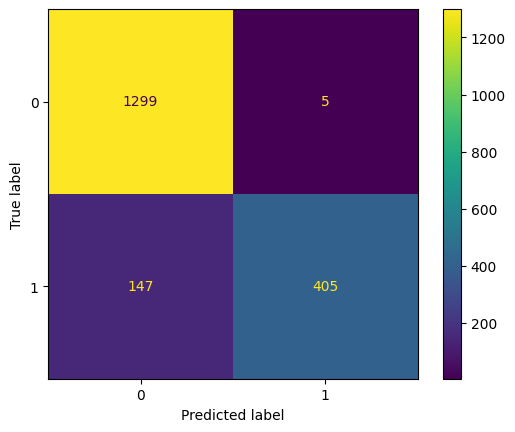

In [143]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_tr,y_cls_p))
disp.plot()
plt.show()

In [144]:
import torch
import torch.nn.functional as F

def binary_cross_entropy_loss_by_image(pred, target):
    """
    Compute binary cross-entropy loss by image in a batch.

    Args:
        pred (torch.Tensor): Predicted probability map (e.g., output of the segmentation model).
                             Shape should be (batch_size, 1, height, width).
        target (torch.Tensor): Ground truth binary segmentation map.
                               Shape should be (batch_size, height, width).

    Returns:
        torch.Tensor: Binary cross-entropy loss for each image in the batch.
                      Shape will be (batch_size,).
    """
    # Reshape the predicted map to match the shape of the target
    pred = pred.view(pred.size(0), -1)  # Flatten each prediction map
    target = target.view(target.size(0), -1)  # Flatten each target map

    # Calculate the binary cross-entropy loss for each image
    loss = F.binary_cross_entropy(pred, target, reduction='none')
    loss = loss.mean(dim=1)  # Take the mean loss across spatial dimensions

    return loss

# Assuming you have predicted and target tensors
# pred size: 10 x 1 x 256 x 256 (10 samples in a batch, single-channel probability map)
# target size: 10 x 256 x 256 (ground truth binary segmentation for each sample)
# batch_bce_loss_by_image = binary_cross_entropy_loss_by_image(pred, target)

In [145]:
y_true.shape

torch.Size([1856, 1, 256, 256])

  0%|          | 0/19 [00:00<?, ?it/s]

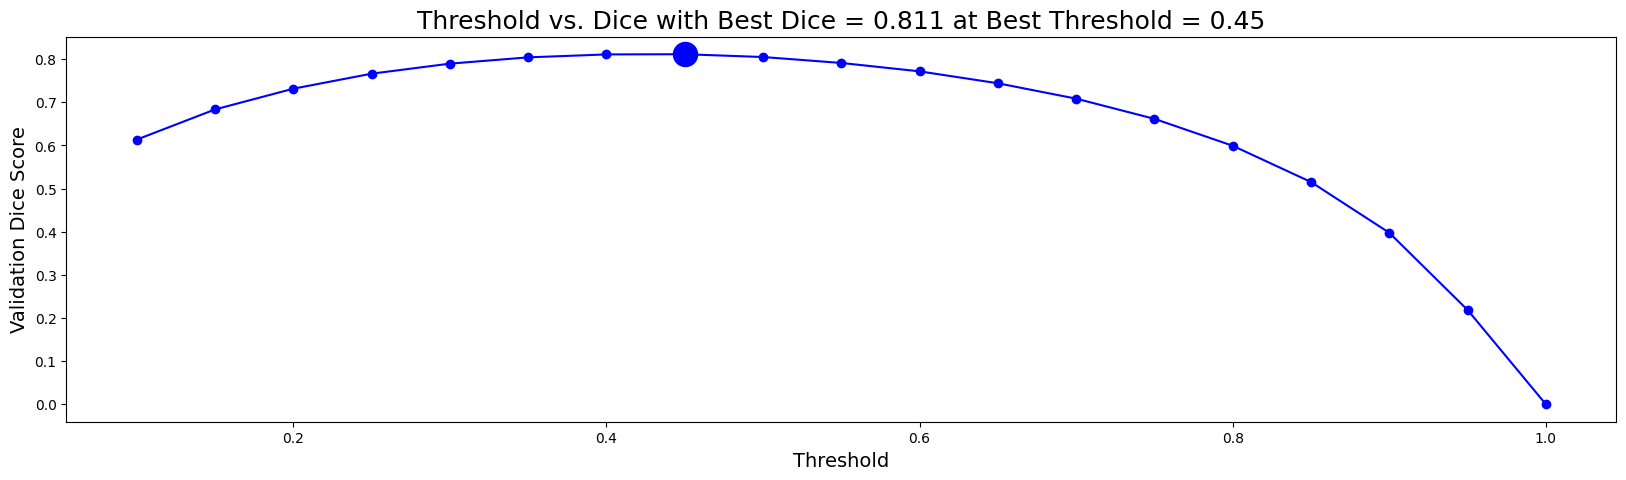

In [146]:
# FIND BEST THRESHOLD TO CONVERT PROBS INTO 1s AND 0s
scores = []; thresholds = []
best_score = 0; best_threshold = 0

for threshold in tqdm(np.arange(0.1,1.05,0.05)):

    m = dice(torch.tensor(y_pred3),y_true.long(),threshold=threshold).item()
    
    scores.append(m)
    thresholds.append(threshold)
    if m>best_score:
        best_score = m
        best_threshold = threshold

# PLOT THRESHOLD VS. F1_SCORE
plt.figure(figsize=(20,5))
plt.plot(thresholds,scores,'-o',color='blue')
plt.scatter([best_threshold], [best_score], color='blue', s=300, alpha=1)
plt.xlabel('Threshold',size=14)
plt.ylabel('Validation Dice Score',size=14)
plt.title(f'Threshold vs. Dice with Best Dice = {best_score:.3f} at Best Threshold = {best_threshold:.3}',size=18)
plt.show()

In [44]:
scores

[0.16265001893043518,
 0.23169644176959991,
 0.30180248618125916,
 0.3673889935016632,
 0.42218953371047974,
 0.47263267636299133,
 0.5232417583465576,
 0.570165753364563,
 0.6133623719215393,
 0.6530066728591919,
 0.6891756653785706,
 0.7216500043869019,
 0.7505589723587036,
 0.7743169069290161,
 0.7922938466072083,
 0.804794192314148,
 0.8110177516937256,
 0.8113496899604797,
 0.8048521876335144]

In [63]:
# Assuming you have 'predictions' and 'ground_truth' tensors
batch_size = y_pred3.size(0)

metric_per_sample = []
for i in tqdm(range(batch_size)):
    
    prediction_single = y_pred3[i].unsqueeze(0)
    ground_truth_single = y_true[i].unsqueeze(0).long()

    # Calculate the Dice metric for the single prediction and ground truth
    dice_score = dice(prediction_single, ground_truth_single.long(),zero_division=1,threshold=0.5)

    # Append the metric score to the list
    metric_per_sample.append(dice_score.item())

# metric_per_sample now contains the Dice metric score for each sample in the batch


  0%|          | 0/1856 [00:00<?, ?it/s]

In [64]:
valid_df['dice'] = metric_per_sample

In [65]:
valid_df['dice'].describe()

count   1856.0000
mean       0.8108
std        0.3279
min        0.0000
25%        0.7372
50%        1.0000
75%        1.0000
max        1.0000
Name: dice, dtype: float64

In [66]:
valid_df['ytrue'] = df_res.ytrue

In [67]:
valid_df['ypred'] = df_res.ypred

In [68]:
valid_df[valid_df['dice']==0].ytrue.value_counts()

ytrue
0    98
1    97
Name: count, dtype: int64

In [69]:
valid_df[valid_df['dice']<0.6].ytrue.value_counts()

ytrue
1    234
0     98
Name: count, dtype: int64

In [71]:
pd.crosstab(valid_df[valid_df['dice']<0.5].ytrue,valid_df[valid_df['dice']<0.6].ypred)

ypred,0,1
ytrue,,
0,0,98
1,87,89


In [193]:
preds_by_fr = (y_pred>0.5).sum(axis=(2,3))
preds_by_fr.shape

torch.Size([2053, 8])

In [194]:
for i in range(8):
    valid_df[f'ypred_fr{i+1}'] = preds_by_fr[:,i]

In [196]:
valid_df[f'ypred_hors_4'] = (valid_df[[f'ypred_fr{i+1}' for i in range(8) if i!=4]].sum(axis=1)>0)*1

In [195]:
valid_df[valid_df['dice']==0]

,record_id,row_min,row_size,col_min,col_size,timestamp,central_meridian,data,month_name,year,hour,is_day,file_name,annot,nb_labels,fold_sk_5_seed_42,fold_sk_10_seed_42,dice,ytrue,ypred,ypred_fr1,ypred_fr2,ypred_fr3,ypred_fr4,ypred_fr5,ypred_fr6,ypred_fr7,ypred_fr8
6,7043106065713062090,4313436.0000,-1970.4082,253984.0312,1953.5997,2019-04-10 20:00:00,-81,train,April,2019,20,0,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,32,1,1,0.0000,1,0,0,0,0,0,0,0,0,0
16,2319747724062812182,3694398.5000,-2033.6230,622599.5000,1889.5331,2019-06-13 10:40:00,-81,train,June,2019,10,1,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,222,1,1,0.0000,1,0,98,33,0,0,0,0,0,0
21,9193061742185459497,3678525.7500,-1964.3138,249157.2656,1955.1024,2019-10-26 22:40:00,-51,train,October,2019,22,0,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,45,1,1,0.0000,1,0,250,342,16,0,0,80,323,307
27,7773250718413322239,3690169.7500,-2019.3802,547917.4375,1902.3683,2019-08-01 12:00:00,-75,train,August,2019,12,1,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,47,1,1,0.0000,1,1,15,0,118,48,25,0,365,363
50,2294634476535387895,3992861.7500,-1977.4514,302783.5312,1944.1897,2020-02-13 22:40:00,-117,train,February,2020,22,0,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,222,1,1,0.0000,1,0,175,195,79,46,0,0,36,0
57,5414996893553475499,4808461.0000,-2028.0736,459499.1875,1899.5369,2019-06-24 23:50:00,-81,train,June,2019,23,0,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,0,1,1,0.0000,0,1,0,0,0,0,2,150,178,0
65,738543978253777490,3468351.0000,-1998.4280,459421.1875,1920.7379,2020-03-11 19:10:00,-99,train,March,2020,19,0,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,38,1,1,0.0000,1,0,0,0,0,0,0,16,0,0
67,5835938944989717096,2696125.0000,-2017.9319,709014.5625,1903.1636,2019-10-01 05:20:00,-75,train,October,2019,5,0,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,79,1,1,0.0000,1,0,83,18,64,0,0,0,0,0
70,8944193494436601377,691733.6875,-1955.6289,530131.8125,1951.2761,2019-10-15 02:40:00,-81,train,October,2019,2,0,/database/kaggle/Identify Contrails/data/3c_al...,5.0000,112,1,1,0.0000,1,0,236,368,116,44,0,0,0,0
80,8606878127218473332,4190788.7500,-2030.0428,535758.2500,1894.3354,2019-10-14 10:40:00,-45,train,October,2019,10,1,/database/kaggle/Identify Contrails/data/3c_al...,4.0000,268,1,1,0.0000,1,0,686,564,417,0,0,0,0,0


In [144]:
# dice(y_pred3,y_true.long(),threshold=0.5,mdmc_average="samplewise").item()

In [72]:
from matplotlib import animation
from IPython import display

In [73]:
def visualize(record_id):

    img = np.load(DATA_PATH/f"host_images/{record_id}_all.npy").astype(np.float32)
    human_pixel_mask = np.load(DATA_PATH/f"train/{record_id}/human_pixel_masks.npy").astype(np.float16)

    plt.figure(figsize=(20, 10))
    for i in range(9):
        ax = plt.subplot(2, 5, i+1)
        j = 0 if i<8 else 1
        i = i if i <8 else 4
        ax.imshow(img[...,i])
        if (i==4) and (j==0):
            ax.imshow(human_pixel_mask, cmap='Reds', alpha=.4, interpolation='none')
        ax.set_title(f'Image {i+1}')

def visualize_labels(record_id):
    human_individual_mask = np.load(DATA_PATH/f"train/{record_id}/human_individual_masks.npy").astype(np.float16)
    n = human_individual_mask.shape[-1]
    plt.figure(figsize=(16, 4))
    for i in range(n):
        plt.subplot(1, n, i+1)
        plt.imshow(human_individual_mask[..., i], interpolation='none')

In [74]:
def visualize_pred(df,preds,record_id):
    
    idx = df[df.record_id.astype(str)==record_id].index
#     print(idx)
    img = np.load(DATA_PATH/f"host_images/{record_id}_all.npy").astype(np.float32)
    human_pixel_mask = (preds[idx].numpy().astype(np.float16)>=0.5)*1
    human_pixel_mask = human_pixel_mask.squeeze(0)
    print(dice(torch.tensor(human_pixel_mask[4]),y_true.squeeze()[idx].long(),threshold=0.5).item())
#     print(human_pixel_mask.shape)
    plt.figure(figsize=(20, 10))
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        ax.imshow(img[...,i])
        ax.imshow(human_pixel_mask[i], cmap='Reds', alpha=.4, interpolation='none')
        ax.set_title(f'Image {i+1}')

In [75]:
# df_res['nb_labels'] = valid_df['nb_labels']

In [76]:
idxes = valid_df[(valid_df.ytrue==1) & (valid_df.ypred==0)].index # & (df_res.nb_labels>200)
len(idxes)

87

In [77]:
dice(y_pred3[idxes],y_true[idxes].long(),threshold=0.5).item()

0.0

In [78]:
record_id = str(valid_df[valid_df.index.isin(idxes)].record_id.sample(1).values[0])
# record_id = "8331520300590033877"
record_id

'2693860474586857615'

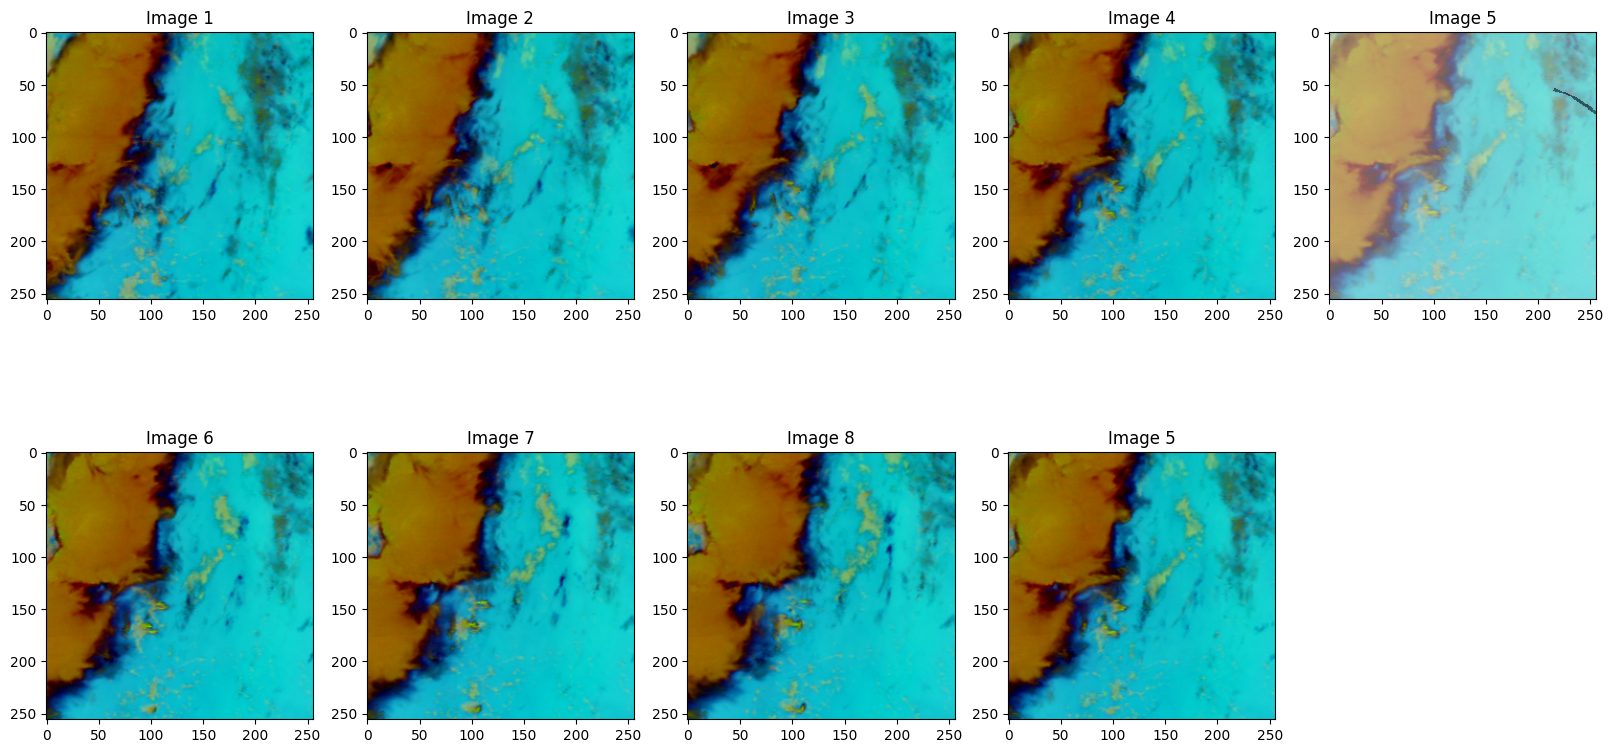

In [79]:
visualize(record_id)

In [82]:
# visualize_labels(record_id)

0.9953155517578125


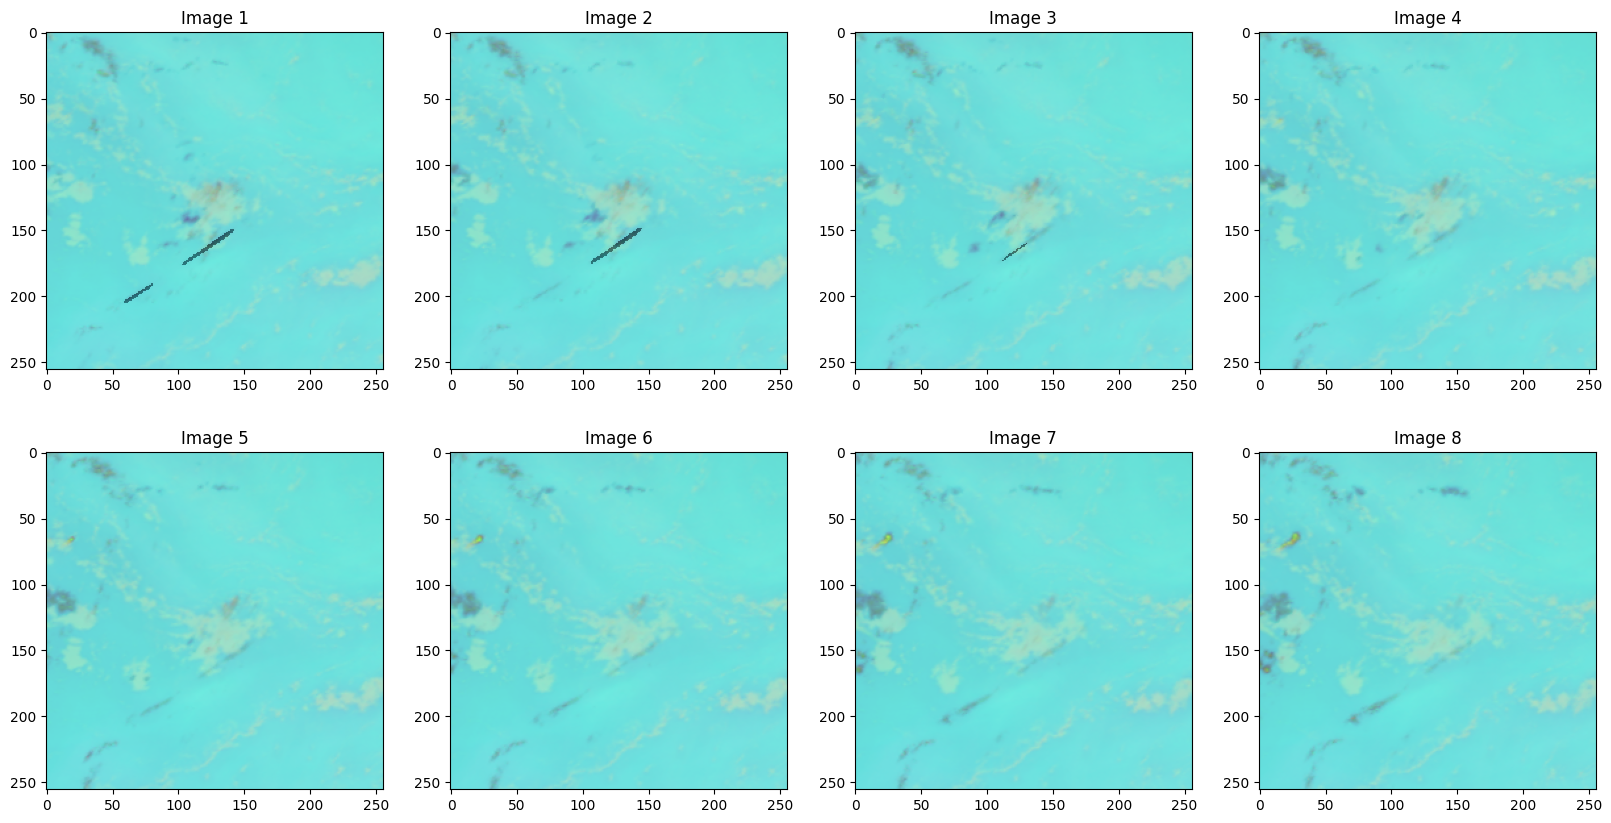

In [191]:
visualize_pred(valid_df,y_pred,record_id)

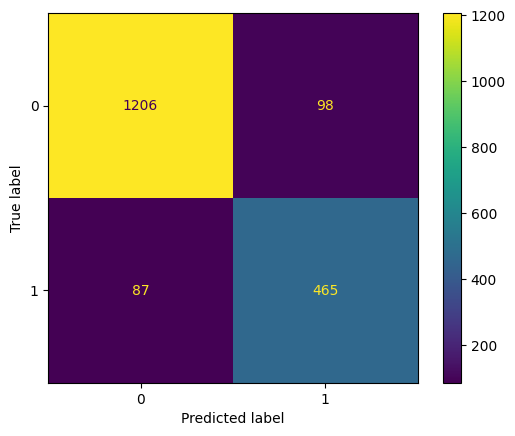

In [81]:
disp = ConfusionMatrixDisplay(confusion_matrix(y_tr,y_cls_p))
disp.plot()
plt.show()

In [199]:
valid_df[(valid_df.ytrue==1) & (valid_df.ypred==0)].ypred_hors_4.value_counts()

ypred_hors_4
1    96
0    24
Name: count, dtype: int64

In [218]:
valid_df[(valid_df.ytrue==1) & (valid_df.ypred==0)].ypred_fr5.value_counts()

ypred_fr5
0    120
Name: count, dtype: int64

In [212]:
valid_df[(valid_df.ytrue==0) & (valid_df.ypred==1)].ypred_fr5.value_counts()

ypred_fr5
2      2
23     2
58     2
5      2
56     2
25     2
61     2
9      2
103    2
94     2
1      2
35     2
7      2
284    1
144    1
95     1
48     1
68     1
81     1
59     1
18     1
75     1
142    1
45     1
38     1
55     1
258    1
52     1
181    1
30     1
115    1
84     1
78     1
72     1
57     1
112    1
36     1
39     1
37     1
107    1
216    1
22     1
3      1
8      1
86     1
117    1
12     1
34     1
96     1
156    1
27     1
Name: count, dtype: int64

In [219]:
valid_df[(valid_df.ytrue==0) & (valid_df.ypred==0)].ypred_hors_4.value_counts()

ypred_hors_4
0    773
1    276
Name: count, dtype: int64

In [ ]:
valid_df[(valid_df.ytrue==0) & (valid_df.ypred==0)].ypred_fr5.value_counts()

In [214]:
valid_df[(valid_df.ytrue==0) & (valid_df.ypred==0)].ypred_fr3.value_counts()

ypred_fr3
0      975
10       3
49       3
12       2
101      2
30       2
91       2
19       2
17       2
46       2
61       2
52       2
87       2
28       2
135      2
68       2
73       1
161      1
194      1
97       1
57       1
34       1
133      1
27       1
322      1
139      1
25       1
6        1
23       1
39       1
173      1
40       1
15       1
140      1
24       1
42       1
8        1
104      1
74       1
51       1
114      1
11       1
153      1
65       1
31       1
109      1
54       1
22       1
189      1
32       1
9        1
102      1
81       1
85       1
18       1
227      1
1        1
3        1
Name: count, dtype: int64

In [216]:
valid_df[(valid_df.ytrue==1) & (valid_df.ypred==1)].ypred_fr5.value_counts()

ypred_fr5
59      5
95      4
67      4
273     4
217     4
       ..
205     1
1712    1
1672    1
32      1
443     1
Name: count, Length: 646, dtype: int64